[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Matsushima_et_al_2023/figure_1.ipynb)

Fig. 1 from [Matsushima 2023 (GMD)](https://doi.org/10.5194/gmd-16-6211-2023) depicting alpha-sampling in PySDM

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np

from PySDM.physics import si, in_unit
from PySDM.initialisation.sampling.spectral_sampling import AlphaSampling
from PySDM.initialisation import spectra

from matplotlib import pyplot, colors
from open_atmos_jupyter_utils import show_plot

In [3]:
n_sd = 2**16
spectrum = spectra.Sum((
    spectra.Lognormal(
        norm_factor=90 / si.cm**3,
        m_mode=0.03 * si.um,
        s_geom=1.28,
    ),
    spectra.Lognormal(
        norm_factor=15 / si.cm**3,
        m_mode=0.14 * si.um,
        s_geom=1.75,
    ),
))

samplings = {
    alpha: AlphaSampling(
        spectrum,
        alpha=alpha,
        interp_points=100000,
        size_range=(10 * si.nm, 5000 * si.nm),
        convert_to="log"
    ) for alpha in np.linspace(0, 1, 11) 
}

xas, yas = {}, {}
for alpha, sampling in samplings.items():
    xas[alpha], yas[alpha] = sampling.sample_deterministic(n_sd)

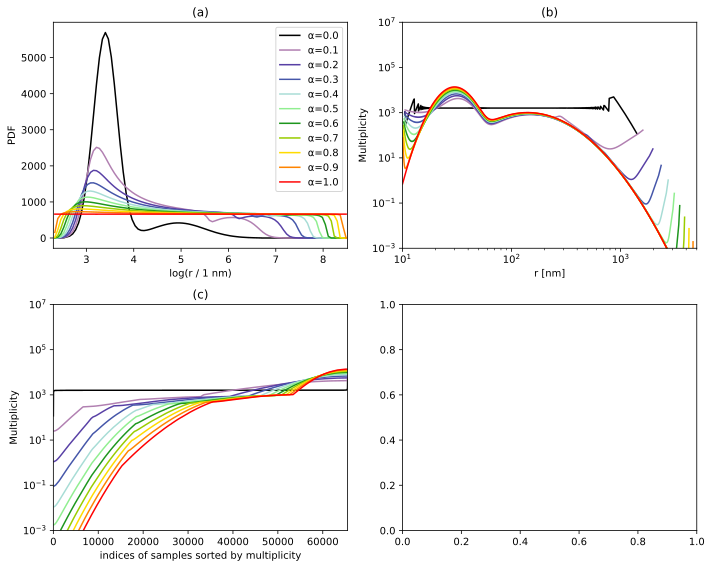

In [4]:
fig,axs = pyplot.subplot_mosaic([['a','b'],['c','']], figsize=(10, 8), tight_layout=True)

xlim = (np.log(10), np.log(5000))

cmap = colors.LinearSegmentedColormap.from_list(
    "mypalette",
    ("black", "plum", "navy", "lightblue", "lightgreen", "green", "yellow", "orange", "red"),
    N=len(samplings)
)

for alpha in samplings:
    kwargs = {'label': f'α={alpha:.1f}', 'color': cmap(alpha)}
    a, b = np.histogram(in_unit(xas[alpha], si.nm), density=False, bins=np.logspace(*xlim, num=100, base=np.e))
    b = np.log(b)
    axs['a'].plot(b[:-1] + np.diff(b) / 2, a, **kwargs)
    axs['b'].plot(in_unit(xas[alpha], si.nm), yas[alpha], **kwargs)
    axs['c'].plot(np.sort(yas[alpha]), **kwargs)
axs['a'].legend()
axs['a'].set( 
     ylabel='PDF', 
     xlabel='log(r / 1 nm)',
     xlim=xlim,
     title='(a)',
)
axs['b'].set(
    xlabel='r [nm]',
    ylabel='Multiplicity',
    xscale='log',
    yscale='log',
    xlim=(10, 5000),
    ylim=(1e-3, 1e7),
    title='(b)'
)
axs['c'].set(
    xlabel='indices of samples sorted by multiplicity',
    ylabel='Multiplicity',
    yscale='log',
    xlim=(0, n_sd),
    ylim=(1e-3, 1e7),
    title='(c)'
)
show_plot('fig_1')